In [1]:
data_path = "/scratch/cl6707/Shared_Datasets/NSD_MindEye"
nsd_root = "/scratch/cl6707/Projects/neuro_interp/data/NSD/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"
subj = 1
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')
sys.path.append('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsd')
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
from models import Clipper, OpenClipper, BrainNetwork, BrainDiffusionPrior, BrainDiffusionPriorOld, Voxel2StableDiffusionModel, VersatileDiffusionPriorNetwork

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

seed=42
utils.seed_everything(seed=seed)
from src.file_utility import load_mask_from_nii, view_data

%matplotlib inline
fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import load_mask_from_nii
from nilearn.decoding import SpaceNetRegressor
import nibabel as nib

subj =1
voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%subj)
voxel_roi_full.shape

# from NSDAccess import NSDAccess
# nsd = NSDAccess('/scratch/cl6707/Projects/neuro_interp/data/NSD/')

if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386
    
    
print('Pulling NSD webdataset data...')
# Multi-GPU config #
from accelerate import Accelerator
accelerator = Accelerator(split_batches=False,mixed_precision='fp16')  
print("PID of this process =",os.getpid())
print = accelerator.print # only print if local_rank=0
device = accelerator.device
print("device:",device)
num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices
print(accelerator.state)
local_rank = accelerator.state.local_process_index
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)



train_url = "{" + f"{data_path}/webdataset_avg_split/train/train_subj0{subj}_" + "{0..17}.tar," + f"{data_path}/webdataset_avg_split/val/val_subj0{subj}_0.tar" + "}"
val_url = f"{data_path}/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
print(train_url,"\n",val_url)
meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982
batch_size = 1
print('Prepping train and validation dataloaders...')

train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
    batch_size,'images',
    num_devices=num_devices,
    num_workers=num_workers,
    train_url=train_url,
    val_url=val_url,
    meta_url=meta_url,
    num_train=num_train,
    num_val=num_val,
    val_batch_size=1,
    cache_dir=data_path, #"/tmp/wds-cache",
    seed=seed,
    voxels_key='nsdgeneral.npy', # 'nsdgeneral.npy' (1d), 'wholebrain_3d.npy'(3d)
    to_tuple=["voxels", "images", "coco","trial"],
    local_rank=local_rank,
    world_size=world_size,
)

device: cpu


2023-12-08 21:36:29.141210: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 21:36:31.603927: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 21:36:32.871231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 21:36:32.871257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 21:36:32.881997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Pulling NSD webdataset data...
PID of this process = 3987289
device: cpu
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cpu

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1
{/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/train/train_subj01_{0..17}.tar,/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/val/val_subj01_0.tar} 
 /scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/test/test_subj01_{0..1}.tar
Prepping train and validation dataloaders...
Getting dataloaders...

num_train 8859
global_batch_size 1
batch_size 1
num_workers 1
num_batches 8859
num_worker_batches 8859

num_val 982
val_num_batches 982
val_batch_size 1


In [28]:
from nilearn.decoding import SpaceNetClassifier
from sklearn.metrics import accuracy_score

nsd_mindroot = '/scratch/cl6707/Shared_Datasets/NSD_MindEye'

things = np.load(nsd_mindroot + '/subj%02d_things.npy'%subj,allow_pickle=True)
things_all = np.concatenate(things, axis=0)
unique_things = np.unique(things_all)
things_val_mapping = {k:i for i,k in enumerate(unique_things)}
val_things_mapping = {i:k for i,k in enumerate(unique_things)}
def get_accuracy(model, X, y):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred)

nsdgeneral_affine = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').affine
nsdgeneral_roi_mask = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').get_fdata()==1

def reconstruct_volume_corrected(vol_shape, binary_mask, data_vol, order='C'):
    
    view_vol = np.ones(np.prod(vol_shape), dtype=np.float32) * np.nan
    
    idx_mask = np.where(binary_mask)[0]
    
    view_vol[idx_mask] = data_vol
    return np.nan_to_num(view_vol.reshape(vol_shape, order=order))

In [3]:
# get all the data:
X_train_all = []
y_train_all = []
X_val_all = []
y_val_all = []

train_iter = iter(train_dl)
test_iter = iter(val_dl)

for i in tqdm(range(num_train)):
    voxels, _, _, trial = next(train_iter)
    voxels = voxels[0].cpu().numpy().mean(axis=0)
    # convert voxels to 3d volume
    voxels = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), voxels)
    nii_voxels = nib.Nifti1Image(voxels, nsdgeneral_affine)
    labels = things[trial]
    # for label in labels:
    #     X_train_all.append(nii_voxels)
    #     y_train_all.append(things_val_mapping[label])
    if len(labels)==1:
        X_train_all.append(nii_voxels)
        y_train_all.append(things_val_mapping[labels[0]])

for i in tqdm(range(num_val)):
    voxels, _, _, trial = next(test_iter)
    voxels = voxels[0].cpu().numpy().mean(axis=0)
    # convert voxels to 3d volume
    voxels = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), voxels)
    nii_voxels = nib.Nifti1Image(voxels, nsdgeneral_affine)
    labels = things[trial]
    # for label in labels:
    #     X_val_all.append(nii_voxels)
    #     y_val_all.append(things_val_mapping[label])
    if len(labels)==1:
        X_val_all.append(nii_voxels)
        y_val_all.append(things_val_mapping[labels[0]])

print('Saving all the data...')
print('len(X_train_all):',len(X_train_all), 'len(y_train_all):',len(y_train_all))
print('len(X_val_all):',len(X_val_all), 'len(y_val_all):',len(y_val_all))
# np.save('/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/3dnii_train_all.npy', X_train_all)
# np.save('/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/label_train_all.npy', y_train_all)
# np.save('/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/3dnii_val_all.npy', X_val_all)
# np.save('/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/label_val_all.npy', y_val_all)

  0%|          | 0/8859 [00:00<?, ?it/s]

  0%|          | 0/982 [00:00<?, ?it/s]

In [5]:

decoder = SpaceNetClassifier(
    memory = 'nilearn_cache',
    penalty='graph-net',
    screening_percentile=5.0,
    memory_level=2,
    standardize="zscore_sample",
)

decoder.fit(X_train_all, y_train_all)

# get accuracy on train and val
train_acc = get_accuracy(decoder, X_train_all, y_train_all)
val_acc = get_accuracy(decoder, X_val_all, y_val_all)
print("Train accuracy:", train_acc)
print("Val accuracy:", val_acc)


[NiftiMasker.fit] Loading data from [Nifti1Image(
shape=(81, 104, 83),
affine=array([[  1.79999995,   0.        ,   0.        , -72.        ],
       [  0.        ,   1.79999995,   0.        , -92.69999695],
       [  0.        ,   0.        ,   1.79999995, -73.80000305],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
),
 Nifti1Image(
shape=(81, 104, 83),
affine=array([[  1.79999995,   0.        ,   0.        , -72.        ],
       [  0.        ,   1.79999995,   0.        , -92.69999695],
       [  0.        ,   0.        ,   1.79999995, -73.80000305],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
),
 Nifti1Image(
shape=(81, 104, 83),
affine=array([[  1.79999995,   0.        ,   0.        , -72.        ],
       [  0.        ,   1.79999995,   0.        , -92.69999695],
       [  0.        ,   0.        ,   1.79999995, -73.80000305],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
),
 Nifti1Image(
shape=(81, 104, 83),
affine=arra

/ext3/miniconda3/lib/python3.10/site-packages/nilearn/maskers/nifti_masker.py:439: UserWarning: Persisting input arguments took 20.23s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  self.mask_img_ = self._cache(compute_mask, ignore=["verbose"])(


[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(81, 104, 83, 2324),
affine=array([[  1.79999995,   0.        ,   0.        , -72.        ],
       [  0.        ,   1.79999995,   0.        , -92.69999695],
       [  0.        ,   0.        ,   1.79999995, -73.80000305],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/ext3/miniconda3/lib/python3.10/site-packages/nilearn/maskers/nifti_masker.py:558: UserWarning: Persisting input arguments took 20.63s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  data = self._cache(


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 214, ..., 2323]), array([  0, ..., 465]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 127.3s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([214, ..., 894]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 124.7s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 498, ..., 1178]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 121.4s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 669, ..., 1450]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 119.5s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 919, ..., 1745]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 123.0s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1241, ..., 1971]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 121.6s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1558, ..., 2126]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 127.2s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2126]), array([1935, ..., 2323]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 117.3s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 214, ..., 2323]), array([  0, ..., 465]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 125.8s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([214, ..., 894]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 129.8s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 498, ..., 1178]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 127.8s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 669, ..., 1450]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 133.1s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 919, ..., 1745]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 131.2s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1241, ..., 1971]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 128.3s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1558, ..., 2126]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 124.7s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2126]), array([1935, ..., 2323]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 124.2s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 214, ..., 2323]), array([  0, ..., 465]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 119.4s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([214, ..., 894]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 126.9s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 498, ..., 1178]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 120.9s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 669, ..., 1450]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 121.4s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 919, ..., 1745]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 122.6s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1241, ..., 1971]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 120.4s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1558, ..., 2126]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 123.4s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2126]), array([1935, ..., 2323]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 120.1s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 214, ..., 2323]), array([  0, ..., 465]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 131.5s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([214, ..., 894]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 131.1s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 498, ..., 1178]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 136.3s, 2.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 669, ..., 1450]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 131.1s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 919, ..., 1745]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 125.8s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1241, ..., 1971]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 127.6s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1558, ..., 2126]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 127.7s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2126]), array([1935, ..., 2323]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 123.4s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 214, ..., 2323]), array([  0, ..., 465]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 129.3s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([214, ..., 894]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 122.9s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 498, ..., 1178]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 124.1s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 669, ..., 1450]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 117.9s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 919, ..., 1745]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 126.7s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1241, ..., 1971]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 117.9s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1558, ..., 2126]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 130.4s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2126]), array([1935, ..., 2323]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 133.2s, 2.2min


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 84.2min


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 214, ..., 2323]), array([  0, ..., 465]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 128.2s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([214, ..., 894]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 135.6s, 2.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 498, ..., 1178]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 128.4s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 669, ..., 1450]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 140.5s, 2.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 919, ..., 1745]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 138.4s, 2.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1241, ..., 1971]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 136.4s, 2.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1558, ..., 2126]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 132.7s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2126]), array([1935, ..., 2323]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 139.1s, 2.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 214, ..., 2323]), array([  0, ..., 465]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 136.1s, 2.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([214, ..., 894]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 136.8s, 2.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 498, ..., 1178]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 130.2s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 669, ..., 1450]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 132.3s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 919, ..., 1745]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 127.9s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1241, ..., 1971]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 136.4s, 2.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1558, ..., 2126]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 132.7s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2126]), array([1935, ..., 2323]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 133.2s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 214, ..., 2323]), array([  0, ..., 465]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 129.7s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([214, ..., 894]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 124.4s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 498, ..., 1178]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 118.7s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 669, ..., 1450]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 126.9s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 919, ..., 1745]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 118.9s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1241, ..., 1971]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 118.8s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1558, ..., 2126]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 124.2s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2126]), array([1935, ..., 2323]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 124.7s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 214, ..., 2323]), array([  0, ..., 465]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


.......

____________________________________________________path_scores - 134.9s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([214, ..., 894]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 135.6s, 2.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 498, ..., 1178]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 131.9s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 669, ..., 1450]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 139.7s, 2.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 919, ..., 1745]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 133.4s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1241, ..., 1971]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 133.1s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1558, ..., 2126]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 128.9s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2126]), array([1935, ..., 2323]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 132.7s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 214, ..., 2323]), array([  0, ..., 465]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 125.8s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([214, ..., 894]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 124.6s, 2.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 498, ..., 1178]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 122.6s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 669, ..., 1450]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 120.8s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 919, ..., 1745]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 122.6s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1241, ..., 1971]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 120.8s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1558, ..., 2126]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 122.6s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2126]), array([1935, ..., 2323]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 120.5s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 214, ..., 2323]), array([  0, ..., 465]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 118.2s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([214, ..., 894]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 115.1s, 1.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 498, ..., 1178]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 120.5s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 669, ..., 1450]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 118.7s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 919, ..., 1745]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 122.3s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1241, ..., 1971]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 119.7s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1558, ..., 2126]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 118.1s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2126]), array([1935, ..., 2323]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 119.7s, 2.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 214, ..., 2323]), array([  0, ..., 465]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(11, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


.......

____________________________________________________path_scores - 131.5s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([214, ..., 894]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(11, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 133.7s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 498, ..., 1178]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(11, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 132.4s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 669, ..., 1450]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(11, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 129.7s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([ 919, ..., 1745]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(11, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 132.3s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1241, ..., 1971]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(11, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 133.0s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2323]), array([1558, ..., 2126]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(11, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........

____________________________________________________path_scores - 134.1s, 2.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef22ed3520>, array([[-0.122967, ..., -1.218891],
       ...,
       [-1.930702, ...,  0.956532]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 2126]), array([1935, ..., 2323]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(11, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


.........

____________________________________________________path_scores - 135.3s, 2.3min
Time Elapsed: 12459.900430440903 seconds, 207.66500717401505 minutes.
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(81, 104, 83, 355),
affine=array([[  1.79999995,   0.        ,   0.        , -72.        ],
       [  0.        ,   1.79999995,   0.        , -92.69999695],
       [  0.        ,   0.        ,   1.79999995, -73.80000305],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/ext3/miniconda3/lib/python3.10/site-packages/nilearn/maskers/nifti_masker.py:558: UserWarning: Persisting input arguments took 3.09s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  data = self._cache(


Train accuracy: 0.9582616179001722
Val accuracy: 0.7492957746478873


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/cl6707/Projects/Neural_Intepretation/notebooks/output/brain_decoding/subj1_coef_img.nii.gz'

In [19]:
train_acc = get_accuracy(decoder, X_train_all, y_train_all)
val_acc = get_accuracy(decoder, X_val_all, y_val_all)
print("Train accuracy:", train_acc)
print("Val accuracy:", val_acc)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(81, 104, 83, 355),
affine=array([[  1.79999995,   0.        ,   0.        , -72.        ],
       [  0.        ,   1.79999995,   0.        , -92.69999695],
       [  0.        ,   0.        ,   1.79999995, -73.80000305],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Train accuracy: 0.9582616179001722
Val accuracy: 0.7492957746478873


/ext3/miniconda3/lib/python3.10/site-packages/nilearn/maskers/nifti_masker.py:558: UserWarning: Persisting input arguments took 3.01s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  data = self._cache(


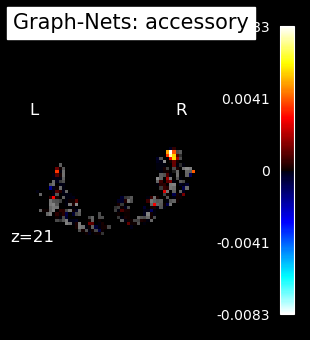

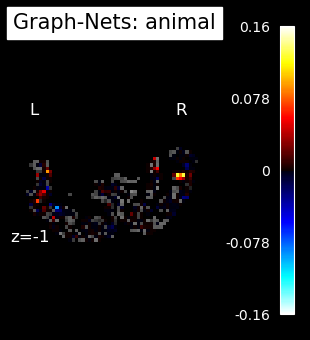

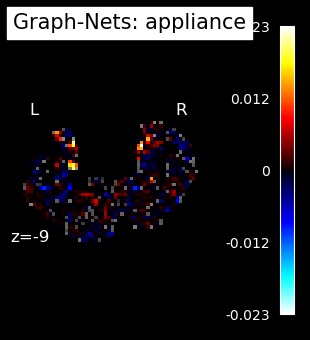

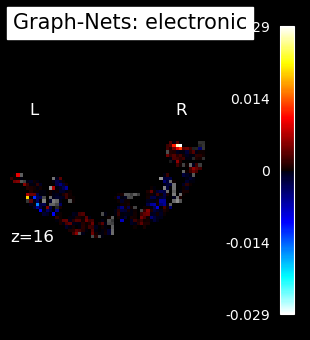

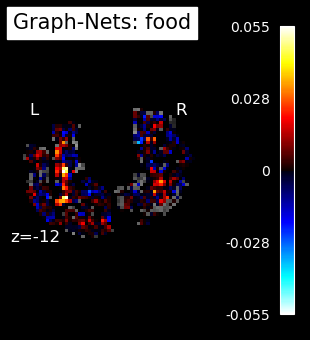

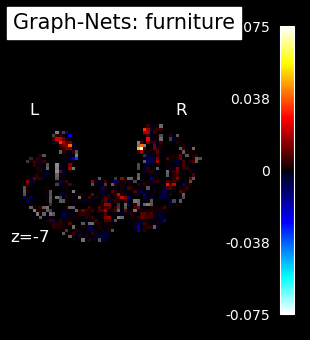

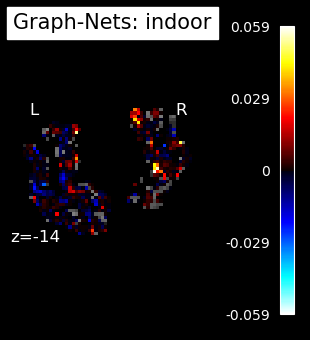

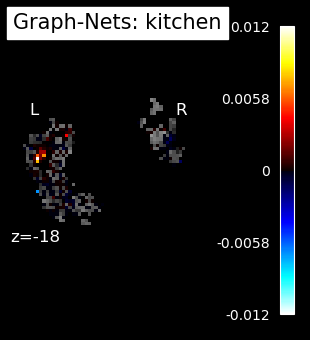

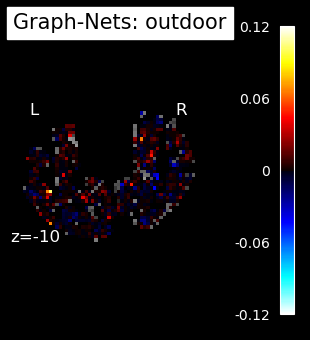

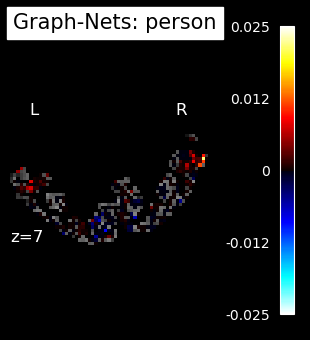

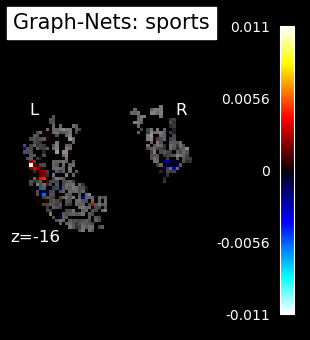

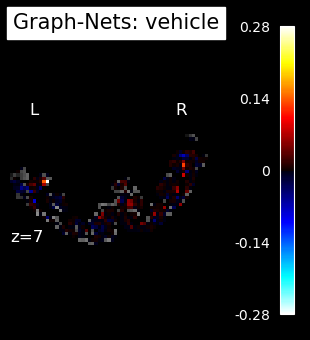

In [33]:
# plot spacenet weights
from nilearn.plotting import plot_stat_map, show
from nilearn.image import index_img
coefficients_img = decoder.coef_img_
background_img = X_val_all[0]
for i in range(12):
    coef_img_3d = index_img(coefficients_img, i)
    plot_stat_map(coef_img_3d, 
                  bg_img = background_img,
                    display_mode='z',
                    cut_coords=1,
                    title = f"Graph-Nets: {val_things_mapping[i]}"
                  )
    # save the plot
    plt.savefig(f'/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/subj{subj}_spacenet_{val_things_mapping[i]}.png')
    # Display the plot
    show()
